In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.5/983.5 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
!pip install ultralytics --quiet
from google.colab import files
import os, zipfile, shutil, random
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from ultralytics import YOLO
from IPython.display import Image, display

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
uploaded = files.upload()  # uploading ZIP with images/ and annotations/ folders
zip_name = list(uploaded.keys())[0]
dataset_dir = '/content/pothole_dataset'

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

Saving archive.zip to archive.zip


In [ ]:
# STEP 3: SPLITING INTO TRAIN / VAL / TEST
import os, random, shutil, zipfile
import xml.etree.ElementTree as ET
from PIL import Image as PILImage
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from google.colab import files
from IPython.display import Image, display

# Setting paths
base_path = '/content/pothole_dataset'
images_path = os.path.join(base_path, 'images')
annotations_path = os.path.join(base_path, 'annotations')

# Listing image files
all_images = sorted([f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Spliting data
train_imgs, testval_imgs = train_test_split(all_images, test_size=0.2, random_state=42)
val_imgs, test_imgs = train_test_split(testval_imgs, test_size=0.5, random_state=42)

splits = {'train': train_imgs, 'val': val_imgs, 'test': test_imgs}

# Creating split folders
for split in splits:
    os.makedirs(f'{base_path}/images/{split}', exist_ok=True)
    os.makedirs(f'{base_path}/annotations/{split}', exist_ok=True)

# Copying image and corresponding annotation
for split, files_list in splits.items():
    for fname in files_list:
        src_img = os.path.join(images_path, fname)
        dst_img = os.path.join(base_path, f'images/{split}/{fname}')
        xml_name = fname.rsplit('.', 1)[0] + '.xml'
        src_xml = os.path.join(annotations_path, xml_name)
        dst_xml = os.path.join(base_path, f'annotations/{split}/{xml_name}')

        if os.path.exists(src_img) and os.path.exists(src_xml):
            shutil.copy2(src_img, dst_img)
            shutil.copy2(src_xml, dst_xml)

# Converting Pascal VOC to YOLO format
def convert_voc_to_yolo(xml_path, img_w, img_h):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    yolo_lines = []
    for obj in root.findall('object'):
        cls_id = 0  # pothole class
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        x_center = ((xmin + xmax) / 2) / img_w
        y_center = ((ymin + ymax) / 2) / img_h
        w = (xmax - xmin) / img_w
        h = (ymax - ymin) / img_h
        yolo_lines.append(f"{cls_id} {x_center} {y_center} {w} {h}")
    return yolo_lines

# Running conversion on all splits
for split in ['train', 'val', 'test']:
    os.makedirs(f'{base_path}/labels/{split}', exist_ok=True)
    split_img_dir = f'{base_path}/images/{split}'
    split_xml_dir = f'{base_path}/annotations/{split}'
    for xml_file in os.listdir(split_xml_dir):
        xml_path = os.path.join(split_xml_dir, xml_file)
        img_file = xml_file.replace('.xml', '.png')  # use .jpg/.jpeg if needed
        for ext in ['.png', '.jpg', '.jpeg']:
            img_path = os.path.join(split_img_dir, img_file.replace('.png', ext))
            if os.path.exists(img_path):
                with PILImage.open(img_path) as im:
                    w, h = im.size
                    yolo_lines = convert_voc_to_yolo(xml_path, w, h)
                    with open(f'{base_path}/labels/{split}/{xml_file.replace(".xml", ".txt")}', 'w') as f:
                        f.write("\n".join(yolo_lines))
                break


In [ ]:
!ls -R /content/pothole_dataset


/content/pothole_dataset:
annotations  data.yaml	images	labels

/content/pothole_dataset/annotations:
potholes0.xml	 potholes250.xml  potholes400.xml  potholes551.xml
potholes100.xml  potholes251.xml  potholes401.xml  potholes552.xml
potholes101.xml  potholes252.xml  potholes402.xml  potholes553.xml
potholes102.xml  potholes253.xml  potholes403.xml  potholes554.xml
potholes103.xml  potholes254.xml  potholes404.xml  potholes555.xml
potholes104.xml  potholes255.xml  potholes405.xml  potholes556.xml
potholes105.xml  potholes256.xml  potholes406.xml  potholes557.xml
potholes106.xml  potholes257.xml  potholes407.xml  potholes558.xml
potholes107.xml  potholes258.xml  potholes408.xml  potholes559.xml
potholes108.xml  potholes259.xml  potholes409.xml  potholes55.xml
potholes109.xml  potholes25.xml   potholes40.xml   potholes560.xml
potholes10.xml	 potholes260.xml  potholes410.xml  potholes561.xml
potholes110.xml  potholes261.xml  potholes411.xml  potholes562.xml
potholes111.xml  potholes262.xm

In [ ]:
import os

def count_files(folder, exts):
    return len([f for f in os.listdir(folder) if f.lower().endswith(exts)])

split_paths = {
    "Train Images": "/content/pothole_dataset/images/train",
    "Val Images": "/content/pothole_dataset/images/val",
    "Test Images": "/content/pothole_dataset/images/test",
    "Train Labels": "/content/pothole_dataset/labels/train",
    "Val Labels": "/content/pothole_dataset/labels/val",
    "Test Labels": "/content/pothole_dataset/labels/test",
}

counts = {name: count_files(path, ('.jpg', '.jpeg', '.png', '.txt')) for name, path in split_paths.items()}
for k, v in counts.items():
    print(f"{k}: {v}")


Train Images: 532
Val Images: 66
Test Images: 67
Train Labels: 532
Val Labels: 66
Test Labels: 67


In [ ]:
from ultralytics import YOLO
from IPython.display import Image, display
import os

In [ ]:
yaml = """
path: /content/pothole_dataset
train: images/train
val: images/val
test: images/test
nc: 1
names: ['pothole']
"""

with open("/content/pothole_dataset/data.yaml", "w") as f:
    f.write(yaml)


In [ ]:
# Step 2: Training YOLOv8 on the dataset
model = YOLO('yolov8n.pt')  # You can switch to 'yolov8s.pt' or 'yolov8m.pt' for higher accuracy

model.train(
    data="/content/pothole_dataset/data.yaml",
    epochs=20,
    imgsz=640,
    batch=16,
    name="pothole_yolov8"
)

Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/pothole_dataset/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=pothole_yolov8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

train: Scanning /content/pothole_dataset/labels/train... 532 images, 0 backgrounds, 0 corrupt: 100%|██████████| 532/532 [00:00<00:00, 863.84it/s]

train: New cache created: /content/pothole_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 605.3±116.7 MB/s, size: 460.5 KB)


val: Scanning /content/pothole_dataset/labels/val... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<00:00, 248.08it/s]

val: New cache created: /content/pothole_dataset/labels/val.cache


Plotting labels to runs/detect/pothole_yolov8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/pothole_yolov8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.13G      1.639      2.649      1.528         32        640: 100%|██████████| 34/34 [00:14<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         66        197      0.769     0.0677      0.225      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.65G      1.576      1.969      1.456          9        640: 100%|██████████| 34/34 [00:12<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]

                   all         66        197      0.478      0.244      0.247      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.67G      1.531      1.848       1.44         12        640: 100%|██████████| 34/34 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]

                   all         66        197        0.1     0.0711     0.0286    0.00718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.69G      1.517      1.726      1.408         12        640: 100%|██████████| 34/34 [00:12<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all         66        197      0.606       0.36      0.403       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.71G      1.508      1.624      1.426         15        640: 100%|██████████| 34/34 [00:10<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


                   all         66        197      0.546      0.437      0.463      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.72G      1.503      1.542      1.401         19        640: 100%|██████████| 34/34 [00:11<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


                   all         66        197       0.65      0.411      0.493      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.74G      1.422      1.489      1.366         13        640: 100%|██████████| 34/34 [00:11<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


                   all         66        197      0.604      0.495      0.534      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.75G      1.429      1.433       1.36         24        640: 100%|██████████| 34/34 [00:11<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all         66        197      0.559      0.487      0.507      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.77G      1.406      1.389       1.35         12        640: 100%|██████████| 34/34 [00:12<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]

                   all         66        197      0.606      0.528      0.577      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.79G      1.382      1.332      1.324         19        640: 100%|██████████| 34/34 [00:11<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         66        197      0.633      0.569      0.615      0.361


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.81G      1.316      1.383      1.306          8        640: 100%|██████████| 34/34 [00:13<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

                   all         66        197      0.635      0.472      0.551      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.82G      1.322       1.28      1.301          9        640: 100%|██████████| 34/34 [00:11<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]

                   all         66        197      0.612      0.545      0.581      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.84G      1.247      1.208      1.243         12        640: 100%|██████████| 34/34 [00:11<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         66        197      0.712      0.539      0.625      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.86G      1.235       1.16      1.238         25        640: 100%|██████████| 34/34 [00:11<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]

                   all         66        197      0.663      0.598      0.653      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.88G      1.209      1.094      1.231          7        640: 100%|██████████| 34/34 [00:11<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         66        197      0.735      0.533      0.631      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.89G      1.172      1.072      1.202          5        640: 100%|██████████| 34/34 [00:11<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]

                   all         66        197      0.673      0.586      0.663      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.91G      1.144     0.9959      1.181         12        640: 100%|██████████| 34/34 [00:11<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        197       0.76      0.563      0.668      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.92G      1.096      0.958      1.159          5        640: 100%|██████████| 34/34 [00:12<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]

                   all         66        197      0.776      0.599      0.674      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.94G      1.087     0.9238       1.15          8        640: 100%|██████████| 34/34 [00:11<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]

                   all         66        197      0.729      0.609      0.681      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.96G      1.065     0.8837      1.135          7        640: 100%|██████████| 34/34 [00:11<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]

                   all         66        197      0.758      0.603      0.692      0.426



20 epochs completed in 0.077 hours.
Optimizer stripped from runs/detect/pothole_yolov8/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/pothole_yolov8/weights/best.pt, 6.2MB

Validating runs/detect/pothole_yolov8/weights/best.pt...
Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


                   all         66        197      0.758      0.603      0.693      0.425
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/pothole_yolov8


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79f2db810650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
metrics = model.val(data="/content/pothole_dataset/data.yaml", split='test')

print("\n🎯 Performance Metrics:")
print(f"mAP@0.5      : {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95 : {metrics.box.map:.4f}")

# Optional: manual precision and recall
cfm = metrics.confusion_matrix.matrix
TP = cfm[1, 1]
FP = cfm[0, 1]
FN = cfm[1, 0]

precision = TP / (TP + FP) if TP + FP > 0 else 0
recall = TP / (TP + FN) if TP + FN > 0 else 0

print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")


Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.3±0.7 ms, read: 1650.8±582.3 MB/s, size: 478.7 KB)


val: Scanning /content/pothole_dataset/labels/test.cache... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


                   all         67        150      0.745       0.74       0.78      0.497
Speed: 9.0ms preprocess, 6.5ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs/detect/pothole_yolov84

🎯 Performance Metrics:
mAP@0.5      : 0.7796
mAP@0.5:0.95 : 0.4974
Precision    : 0.0000
Recall       : 0.0000


In [ ]:
# Step 4: Running predictions on test images and save results
model.predict(
    source="/content/pothole_dataset/images/test",
    conf=0.25,
    save=True,
    name="pothole_test_preds"
)



image 1/67 /content/pothole_dataset/images/test/potholes10.png: 640x640 1 pothole, 7.3ms
image 2/67 /content/pothole_dataset/images/test/potholes125.png: 384x640 1 pothole, 36.8ms
image 3/67 /content/pothole_dataset/images/test/potholes126.png: 384x640 5 potholes, 6.7ms
image 4/67 /content/pothole_dataset/images/test/potholes147.png: 448x640 1 pothole, 34.3ms
image 5/67 /content/pothole_dataset/images/test/potholes152.png: 640x640 2 potholes, 8.0ms
image 6/67 /content/pothole_dataset/images/test/potholes155.png: 640x640 1 pothole, 7.3ms
image 7/67 /content/pothole_dataset/images/test/potholes157.png: 640x640 1 pothole, 7.3ms
image 8/67 /content/pothole_dataset/images/test/potholes163.png: 640x640 5 potholes, 7.3ms
image 9/67 /content/pothole_dataset/images/test/potholes171.png: 448x640 6 potholes, 6.8ms
image 10/67 /content/pothole_dataset/images/test/potholes176.png: 640x640 1 pothole, 9.2ms
image 11/67 /content/pothole_dataset/images/test/potholes18.png: 288x640 1 pothole, 33.6ms
im

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'pothole'}
 obb: None
 orig_img: array([[[179, 183, 182],
         [177, 182, 180],
         [182, 186, 185],
         ...,
         [171, 183, 189],
         [207, 219, 225],
         [178, 190, 196]],
 
        [[179, 184, 182],
         [177, 182, 180],
         [179, 183, 182],
         ...,
         [130, 141, 148],
         [174, 186, 192],
         [196, 208, 214]],
 
        [[174, 178, 177],
         [174, 179, 177],
         [174, 179, 177],
         ...,
         [137, 149, 156],
         [142, 153, 160],
         [169, 181, 187]],
 
        ...,
 
        [[ 92,  97,  96],
         [ 85,  89,  89],
         [ 86,  90,  89],
         ...,
         [126, 130, 131],
         [127, 131, 132],
         [115, 120, 121]],
 
        [[ 93,  97,  97],
         [ 91,  95,  94],
         [109, 114, 113],
         ...,
         [121, 12


📸 Sample prediction:


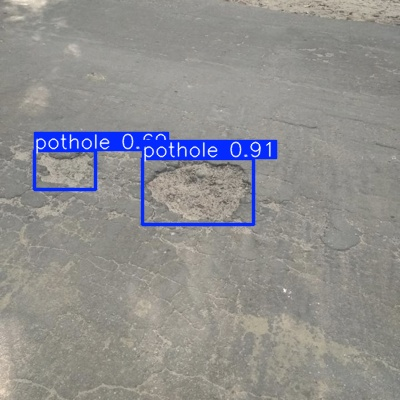

In [ ]:
# Step 5: Displaying a sample predicted image
result_dir = "runs/detect/pothole_test_preds"
predictions = [f for f in os.listdir(result_dir) if f.lower().endswith(('.jpg', '.png'))]

if predictions:
    print("\n📸 Sample prediction:")
    display(Image(filename=os.path.join(result_dir, predictions[0])))
else:
    print("⚠️ No predictions found to display.")

In [ ]:
from google.colab import files
from ultralytics import YOLO
import os
from IPython.display import Image, display

# Step 1: Uploading custom image
uploaded = files.upload()

# Getting the first uploaded filename
img_path = list(uploaded.keys())[0]

# Step 2: Load the trained model
model = YOLO('runs/detect/pothole_yolov8/weights/best.pt')  # Adjust path if needed

# Step 3: Running prediction
results = model.predict(
    source=img_path,
    conf=0.25,
    save=True,
    name='custom_image_result'
)

# Step 4: Displaying the result
result_path = os.path.join('runs/detect/custom_image_result', img_path)
if os.path.exists(result_path):
    print(f"🔍 Showing prediction for: {img_path}")
    display(Image(filename=result_path))
else:
    print("❌ Prediction image not found.")


Saving potholes17.png to potholes17.png

image 1/1 /content/potholes17.png: 448x640 1 pothole, 9.2ms
Speed: 3.9ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/custom_image_result
❌ Prediction image not found.


Saving potholes53.png to potholes53.png

image 1/1 /content/potholes53.png: 448x640 5 potholes, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/uploaded_result
✅ Detection complete for: potholes53.png


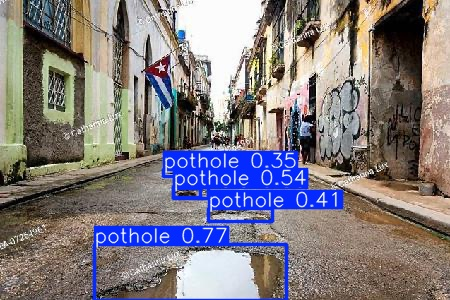

In [52]:
from google.colab import files
from ultralytics import YOLO
from IPython.display import Image, display
import os, shutil, glob

# Step 1: Upload image from the computer
uploaded = files.upload()
uploaded_filename = list(uploaded.keys())[0]

# Step 2: Cleaning previous predictions
result_dir = "runs/detect/uploaded_result"
if os.path.exists(result_dir):
    shutil.rmtree(result_dir)  # Delete previous predictions

# Step 3: Loading the trained YOLOv8 model
model = YOLO('runs/detect/pothole_yolov8/weights/best.pt')

# Step 4: Predicting on uploaded image
model.predict(
    source=uploaded_filename,
    conf=0.25,
    save=True,
    name="uploaded_result"
)

# Step 5: Find and show the newest result image
result_images = glob.glob(f"{result_dir}/*.jpg") + glob.glob(f"{result_dir}/*.png")
if result_images:
    print(f"✅ Detection complete for: {uploaded_filename}")
    display(Image(filename=result_images[0]))
else:
    print("❌ Error: Result image not found.")
